In [ ]:
import os 
import cv2
import pandas as pd
import numpy as np 
from PyFunctions import var
import pickle 
import random

### ROI and Sliding Window

- Inspiration and Guidence for the code below came from [Adrian Rosebrock- PyImageSearch](https://www.pyimagesearch.com/2020/07/13/r-cnn-object-detection-with-keras-tensorflow-and-deep-learning/)

The general flow of our algorithm will be:

1. **Step #1:** Input an image
2. **Step #2:** Construct an image pyramid
3. **Step #3:** For each scale of the image pyramid, run a sliding window
4. **Step #3a:** For each stop of the sliding window, extract the ROI
5. **Step #3b:** Take the ROI and pass it through our CNN originally trained for image classification
6. **Step #3c:** Examine the probability of the top class label of the CNN, and if meets a minimum confidence, record (1) the class label and (2) the location of the sliding window
7. **Step #4:** Apply class-wise non-maxima suppression to the bounding boxes
8. **Step #5:** Return results to calling function

In [ ]:
def get_iou(box1, box2):
    # determine the (x, y)-coordinates of the intersection rectangle
    xa = max(box1[0], box2[0])
    ya = max(box1[1], box2[1])
    xb = min(box1[2], box2[2])
    yb = min(box1[3], box2[3])
    # compute the area of intersection rectangle
    interArea = max(0, xb - xa + 1) * max(0, yb - ya + 1)
    
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    boxBArea = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

- Below, the cell will take the folder where each picture is separated into Rifle, and Hand gun folder 
- iterate through each file and find its corresponding xml file which contains the coordinates of the bounding box 
- Create a sliding window that scans the image and creates new boxes
- After creating many different boxes, it will find the intersection of each new box to the original bounding box that is over the gun
- If the intersection is greater than .7, it will be used as a positive image (gun)
- If the intersection is equl to 0, it will be used a negative image (no gun)
- Separated Folder containing images of guns can be found on my [Google Drive](https://drive.google.com/file/d/1EZZKhCk0DK3S9zB53o3nWhKrZUbmN2Up/view?usp=sharing)
    - If you download the zip file you do not need to run the code below as it can take an hour or more depending on the speed of your computer. 
    - the folder linked above will have everything you need to model 
    
- Images of people were taken from the internet which can be found here [Google Drive](https://drive.google.com/file/d/13PP-I6VdRt0mrVkquFxF_Y2HO6S1E0lR/view?usp=sharing)
- Final model used the hand_dataset as a negative, and the roi images created below as the positive (handgun, rifle)
- In the notebook below, we will the compare the accuracy and performance when using the negative ROi compared with the negative images creates in the code block below
- The difference between the two iterations is that one uses negative images that are made from the positive images, while the other uses negative images obtained from a completely different dataset

In [ ]:
from tqdm import tqdm
folder ='Separated'
df = pd.read_csv(f'../{folder}/PATHS.csv').drop('Unnamed: 0', axis =1)

zipped_paths = df[['filename']]

max_prop = 2000
max_pos = 2
max_neg = 3
input_dim = var.norm_dimension
total_pos = 0 
total_neg = 0
error_array = [] 
total_max_neg = 5000
pbar = tqdm(range(len(df)))
for idx in pbar: 
    row = df.iloc[idx]
    img_path = row.filename
    pbar.set_description(f'{img_path}')
    try:
        image = cv2.imread(f'../Separated/Pistol/{img_path}')
        ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
        ss.setBaseImage(image)
        ss.switchToSelectiveSearchFast()
        rects = ss.process() 
        prop_rect = [] 

        xMin = row.xmin
        xMax = row.xmax
        yMin = row.ymin
        yMax = row.ymax
        gt_box = ((xMin, yMin, xMax, yMax))
        gt_startx, gt_starty, gt_endx, gt_endy = gt_box
        for (x,y,w,h) in rects: 
            prop_rect.append((x,y,x+w, y+h))
        positive = 0 
        negative = 0 
        for rect in prop_rect[:1000]: 
            startx, starty, endx, endy = rect
            iou = get_iou(gt_box, rect)
            #if intersection is greater than .7 --> positive
            if iou > .7 and positive < max_pos: 
                roi = image[starty:endy, startx:endx]
                filename = f'{total_pos}.png'
                positive += 1
                total_pos += 1 
                roi = cv2.resize(roi, input_dim, interpolation = cv2.INTER_CUBIC)
                cv2.imwrite(f'../Separated/FinalImages/Pistol/{filename}', roi)
                continue

            fullOverlap = startx >= gt_startx
            fullOverlap = fullOverlap and starty >= gt_starty
            fullOverlap = fullOverlap and endx <= gt_endx
            fullOverlap = fullOverlap and endy <= gt_endy
            
            #if intersection is == 0, than it is negative
            if not fullOverlap and iou == 0 and negative <= max_neg: 
                roi = image[starty:endy, startx: endx]
                filename = f'{total_neg}.png'
                negative += 1
                total_neg += 1
                roi = cv2.resize(roi, input_dim, interpolation = cv2.INTER_CUBIC)
                cv2.imwrite(f'../Separated/FinalImages/NoWeapon/{filename}', roi)
                continue 
    except: 
        try: 
            image = cv2.imread(f'../Separated/AR/{img_path}')
            ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            rects = ss.process() 
            prop_rect = [] 

            xMin = row.xmin
            xMax = row.xmax
            yMin = row.ymin
            yMax = row.ymax
            gt_box = ((xMin, yMin, xMax, yMax))
            gt_startx, gt_starty, gt_endx, gt_endy = gt_box
            for (x,y,w,h) in rects: 
                prop_rect.append((x,y,x+w, y+h))
            positive = 0 
            negative = 0 
            for rect in prop_rect[:1000]: 
                startx, starty, endx, endy = rect
                iou = get_iou(gt_box, rect)
                if iou > .7 and positive < max_pos: 
                    roi = image[starty:endy, startx:endx]
                    filename = f'{total_pos}.png'
                    positive += 1
                    total_pos += 1 
                    roi = cv2.resize(roi, input_dim, interpolation = cv2.INTER_CUBIC)
                    cv2.imwrite(f'../Separated/FinalImages/Rifle/{filename}', roi)
                    continue

                fullOverlap = startx >= gt_startx
                fullOverlap = fullOverlap and starty >= gt_starty
                fullOverlap = fullOverlap and endx <= gt_endx
                fullOverlap = fullOverlap and endy <= gt_endy

                if not fullOverlap and iou == 0 and negative <= max_neg: 
                    roi = image[starty:endy, startx: endx]
                    filename = f'{total_neg}.png'
                    negative += 1
                    total_neg += 1
                    roi = cv2.resize(roi, input_dim, interpolation = cv2.INTER_CUBIC)
                    cv2.imwrite(f'../Separated/FinalImages/NoWeapon/{filename}', roi)
                    continue 
        except: 
            error_array.append((img_path, image))
            continue

#saves the error files in a pickle for investigation later on
pickle.dump(error_array, open('../Pickles/error_array1.p', 'wb'))        
    
    



## Train Test Split

In [ ]:
from PyFunctions import Functions as func

- calling the function below creates a pickled train_test_splits that correspond to a specific dimension and image type and return the train test split in case you do not wish to use the pickles.
- Passing the parameter `normal` for the first argument creates a pickle file corresponding to the dimensions of the CNN that I made.  Other possible entries are `vgg16` and `mobilenet`
- Passing `edge = True` creates a pickled file that contains edged photos rather than the originals 
- Passing `version = 1` creates a file where the negative data is that of the hand dataset
- passing `version =2 ` creates a file where the negative data is the that of the negative ROI obtained above
- passing `balance = True` creates a balanced dataset where there is no class that has a higher frequency
- this notebook was created separately in order to test how it works and not interupt the flow of the CNN notebook
- To change the dimensions of the models, alter the variables found in Var.py within the PyFunctions folder

In [ ]:
x_train, x_test, y_train, y_test = func.get_tts('normal', version = 1, edge = False, balance = True)

# CNN Model 

- The function below will compile and return a CNN model given the input dimensions 
- Categorical Crossentropy was used because the model is used to predict between three classes (0 = No Weapon, 1 = Handgun, 2 = Rifle) 
- Softmax output was used because this is a ternary classification problem 
- To ensure that training continued for more than 20 epochs lerning rate was reduced to .0001
- All visualization functions can be found in the Viz.py file within the PyFunctions folder

- For each iteration of the model, we will compare the results between augmentation and non-augmentation, edge and no edge,  as well as the results between using ROI negative dataset compared with the hand_dataset of people
- For each version, there will be 4 iterations of the model, combining to a total of 8 run throughs
    - **Version 1** (ROI and Hand Dataset)
        - Edge and Augmentation 
        - Edge and no Augmentation 
        - No edge and Augmentation 
        - No edge and No Augmentation
    - **Version 2** (ROI only)
        - Edge and Augmentation 
        - Edge and no Augmentation 
        - No edge and Augmentation 
        - No edge and No Augmentation
- Augmentation is used when you want to create more data from the data you already have.  A reason why augmentation can be so helpful is because it can allow your model to train off of features that may not have seemed important otherwise.  Applying augmentation will randomly rotate and distort every image so that your model can become more generalizable when presented with new, untrained data. 

In [1]:
import numpy as np 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten 
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from keras.optimizers import Adam
from keras import regularizers
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import pickle
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from PyFunctions import Functions as func
from PyFunctions import var
from PyFunctions import Viz
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
import cv2


def get_conv_model(dim):
    '''This function will create and compile a CNN given the input dimension'''
    inp_shape = dim
    act = 'relu'
    drop = .25
    kernal_reg = regularizers.l1(.001)
    optimizer = Adam(lr = .0001)
    
    model = Sequential() 
    
    model.add(Conv2D(64, kernel_size=(3,3),activation=act, input_shape = inp_shape, 
                     kernel_regularizer = kernal_reg,
                     kernel_initializer = 'he_uniform',  padding = 'same', name = 'Input_Layer'))
    model.add(MaxPooling2D(pool_size=(2, 2),  strides = (3,3)))
    
    
    model.add(Conv2D(64, (3, 3), activation=act, kernel_regularizer = kernal_reg, 
                     kernel_initializer = 'he_uniform',padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (3,3)))
    

    
    model.add(Conv2D(128, (3, 3), activation=act, kernel_regularizer = kernal_reg, 
                     kernel_initializer = 'he_uniform',padding = 'same'))
    model.add(Conv2D(128, (3, 3), activation=act, kernel_regularizer = kernal_reg, 
                     kernel_initializer = 'he_uniform',padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (3,3)))

    
    model.add(Flatten())

    
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))

    model.add(Dropout(drop))

    model.add(Dense(3, activation='softmax', name = 'Output_Layer'))
    
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model 

Using plaidml.keras.backend backend.


# Version 1
- In this version, we will compare augmentation and edge detection within the version 1 dataset, which contains the following: 
    - 0 = No weapon (from the hand dataset) 
    - 1 = Pistol (From ROI) 
    - 2 = From (ROI) 

### V1: Edge Detection and Augmentation

In [2]:
x_train, x_test, y_train, y_test = func.get_tts('normal', version = 1, edge = True, balance = True)

#test if it worked
cv2.imshow('test', x_train[25])
cv2.waitKey(0)
cv2.destroyAllWindows()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 441/441 [00:00<00:00, 472.56it/s]


Train Value Counts
1    1368
0    1368
2    1233
dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Test Value Counts
1    152
0    152
2    137
dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
X Train Shape
(3969, 150, 150, 1)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
X Test Shape
(441, 150, 150, 1)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [39]:
#prevents overfitting and saves models every time the validation loss improves
early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience=10, min_delta = .00075)
model_checkpoint = ModelCheckpoint('ModelWeights/V1_Edge_Augmentation.h5', verbose = 1, save_best_only=True,
                                  monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')

epochs = 1000
batch_size = 32

dim = (var.norm_dimension[0], var.norm_dimension[1], 1) #edge is 1 dimensional
model = get_conv_model(dim)
augmentation =ImageDataGenerator(rotation_range = 20, width_shift_range = .2, height_shift_range = .2, 
                                                       horizontal_flip = True, shear_range = .15, 
                                 fill_mode = 'nearest', zoom_range = .15)
augmentation.fit(x_train)
normal_history = model.fit_generator(augmentation.flow(x_train, y_train, batch_size = batch_size),
            epochs = epochs, 
     callbacks = [early_stopping, model_checkpoint, lr_plat], validation_data = (x_test, y_test), verbose= 1)

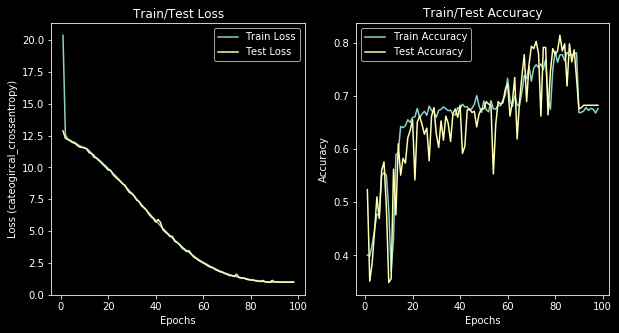

In [4]:
Viz.plot_loss_accuracy(normal_history, 'dark_background', path = 'figures/V1LossAcc_Edge_Augmentation.png')  

F1 Scores Test
~~~~~~~~~~~~~~~~~~~~~~
No Weapon: 1.0
HandGun: 0.6466165413533834
Rifle: 0.6987179487179487


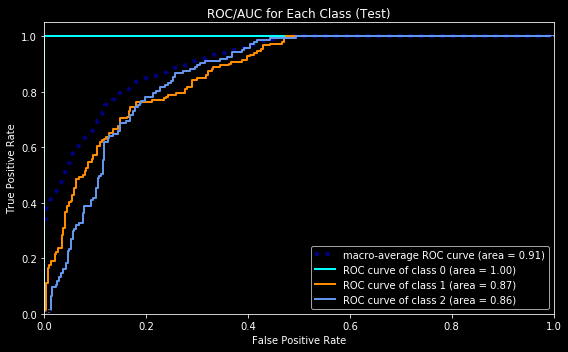

In [6]:
normal_model = get_conv_model(dim)
normal_model.load_weights('ModelWeights/V1_Edge_Augmentation.h5') #load the best weights before overfitting

Viz.plot_roc_auc(normal_model, x_test, y_test, 'dark_background', 'figures/V1ROC_Edge_Augmentation.png')

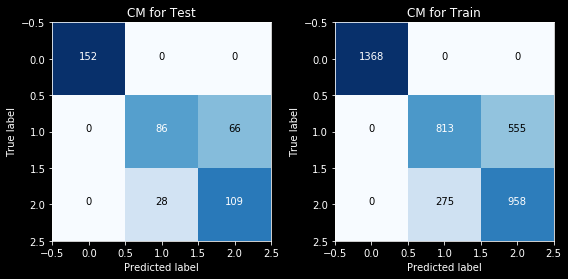

In [7]:
normal_model = get_conv_model(dim)
normal_model.load_weights('ModelWeights/V1_Edge_Augmentation.h5') #load the best weights before overfitting

y_test_prob = [np.argmax(i) for i in normal_model.predict(x_test)]
y_test_labels = [np.argmax(
    i) for i in y_test]
test_cnf = confusion_matrix(y_test_labels, y_test_prob)

y_train_prob = [np.argmax(i) for i in normal_model.predict(x_train)]
y_train_labels = [np.argmax(i) for i in y_train]
train_cnf = confusion_matrix(y_train_labels, y_train_prob)

Viz.plot_model_cm(test_cnf, train_cnf, classes = ['No Weapon', 'Handgun', 'Rifle'], theme = 'dark_background', 
                  path = 'figures/V1CM_Edge_Augmentation.png')


### V1: Edge Detection and No Augmentation

In [40]:
early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience=10, min_delta = .00075)
model_checkpoint = ModelCheckpoint('ModelWeights/V1_Edge_NoAugmentation.h5', verbose = 1, save_best_only=True,
                                  monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')
epochs = 1000
batch_size = 32

dim = (var.norm_dimension[0], var.norm_dimension[1], 1)
    
model = get_conv_model(dim =dim)


normal_history = model.fit(x_train, y_train, batch_size = batch_size,
            epochs = epochs, 
     callbacks = [early_stopping, model_checkpoint, lr_plat], validation_data = (x_test, y_test), verbose= 1)


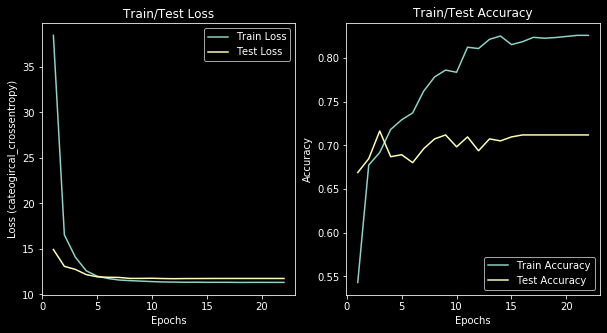

In [9]:
Viz.plot_loss_accuracy(normal_history, 'dark_background', path = 'figures/V1LossAcc_Edge_NoAugmentation.png')  

F1 Scores Test
~~~~~~~~~~~~~~~~~~~~~~
No Weapon: 0.9934640522875817
HandGun: 0.49814126394052044
Rifle: 0.5667752442996742


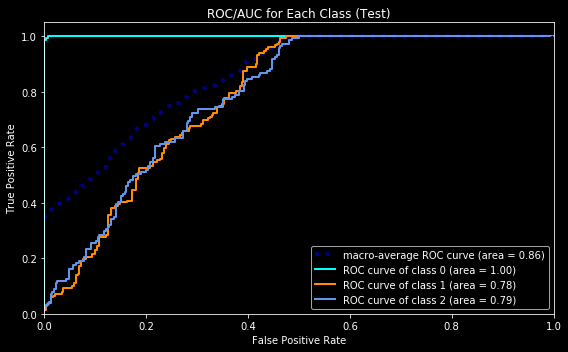

In [10]:
normal_model = get_conv_model(dim)
normal_model.load_weights('ModelWeights/V1_Edge_NoAugmentation.h5') #load the best weights before overfitting

Viz.plot_roc_auc(normal_model, x_test, y_test, 'dark_background', 'figures/V1ROC_Edge_NoAugmentation.png')

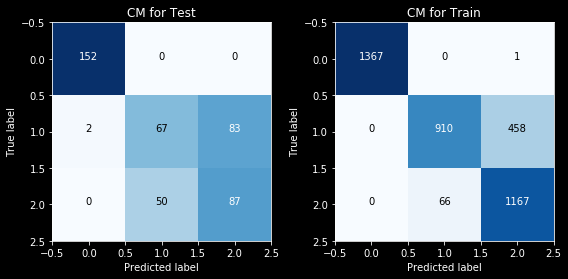

In [11]:
normal_model = get_conv_model(dim)
normal_model.load_weights('ModelWeights/V1_Edge_NoAugmentation.h5') #load the best weights before overfitting

y_test_prob = [np.argmax(i) for i in normal_model.predict(x_test)]
y_test_labels = [np.argmax(
    i) for i in y_test]
test_cnf = confusion_matrix(y_test_labels, y_test_prob)

y_train_prob = [np.argmax(i) for i in normal_model.predict(x_train)]
y_train_labels = [np.argmax(i) for i in y_train]
train_cnf = confusion_matrix(y_train_labels, y_train_prob)

Viz.plot_model_cm(test_cnf, train_cnf, classes = ['No Weapon', 'Handgun', 'Rifle'], theme = 'dark_background', 
                  path = 'figures/V1CM_Edge_NoAugmentation.png')


### V1: No Edge and Augmenatation

In [12]:
x_train, x_test, y_train, y_test = func.get_tts('normal', version = 1, edge = False, balance = True)

#test if it worked
cv2.imshow('test', x_train[25])
cv2.waitKey(0)
cv2.destroyAllWindows()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 441/441 [00:00<00:00, 636.39it/s]


Train Value Counts
1    1368
0    1368
2    1233
dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Test Value Counts
1    152
0    152
2    137
dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
X Train Shape
(3969, 150, 150, 3)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
X Test Shape
(441, 150, 150, 3)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [41]:
#prevents overfitting and saves models every time the validation loss improves
early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience=10, min_delta = .00075)
model_checkpoint = ModelCheckpoint('ModelWeights/V1_NoEdge_Augmentation.h5', verbose = 1, save_best_only=True,
                                  monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')

epochs = 1000
batch_size = 32

dim = (var.norm_dimension[0], var.norm_dimension[1], 3) #Non edge is 3 dimensional
model = get_conv_model(dim)
augmentation =ImageDataGenerator(rotation_range = 20, width_shift_range = .2, height_shift_range = .2, 
                                                       horizontal_flip = True, shear_range = .15, 
                                 fill_mode = 'nearest', zoom_range = .15)
augmentation.fit(x_train)
normal_history = model.fit_generator(augmentation.flow(x_train, y_train, batch_size = batch_size),
            epochs = epochs, 
     callbacks = [early_stopping, model_checkpoint, lr_plat], validation_data = (x_test, y_test), verbose= 1)

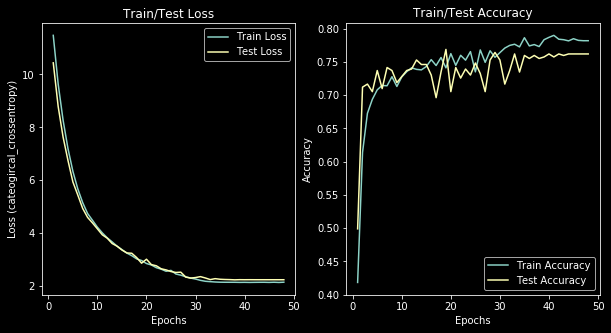

In [14]:
Viz.plot_loss_accuracy(normal_history, 'dark_background', path = 'figures/V1LossAcc_NoEdge_Augmentation.png')  

F1 Scores Test
~~~~~~~~~~~~~~~~~~~~~~
No Weapon: 0.8875739644970414
HandGun: 0.6844106463878326
Rifle: 0.6619217081850534


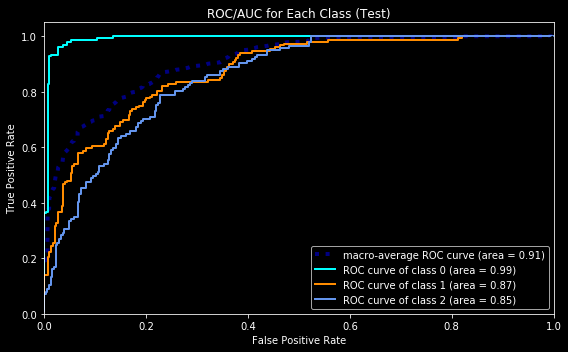

In [15]:
normal_model = get_conv_model(dim)
normal_model.load_weights('ModelWeights/V1_NoEdge_Augmentation.h5') #load the best weights before overfitting

Viz.plot_roc_auc(normal_model, x_test, y_test, 'dark_background', 'figures/V1ROC_NoEdge_Augmentation.png')

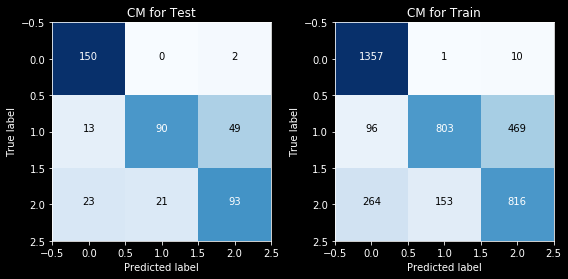

In [16]:
normal_model = get_conv_model(dim)
normal_model.load_weights('ModelWeights/V1_NoEdge_Augmentation.h5') #load the best weights before overfitting

y_test_prob = [np.argmax(i) for i in normal_model.predict(x_test)]
y_test_labels = [np.argmax(
    i) for i in y_test]
test_cnf = confusion_matrix(y_test_labels, y_test_prob)

y_train_prob = [np.argmax(i) for i in normal_model.predict(x_train)]
y_train_labels = [np.argmax(i) for i in y_train]
train_cnf = confusion_matrix(y_train_labels, y_train_prob)

Viz.plot_model_cm(test_cnf, train_cnf, classes = ['No Weapon', 'Handgun', 'Rifle'], theme = 'dark_background', 
                  path = 'figures/V1CM_NoEdge_Augmentation.png')


### V1: No Edge and No Augmentation

In [42]:
early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience=10, min_delta = .00075)
model_checkpoint = ModelCheckpoint('ModelWeights/V1_NoEdge_NoAugmentation.h5', verbose = 1, save_best_only=True,
                                  monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')
epochs = 1000
batch_size = 32

dim = (var.norm_dimension[0], var.norm_dimension[1], 3)
    
model = get_conv_model(dim =dim)


normal_history = model.fit(x_train, y_train, batch_size = batch_size,
            epochs = epochs, 
     callbacks = [early_stopping, model_checkpoint, lr_plat], validation_data = (x_test, y_test), verbose= 1)


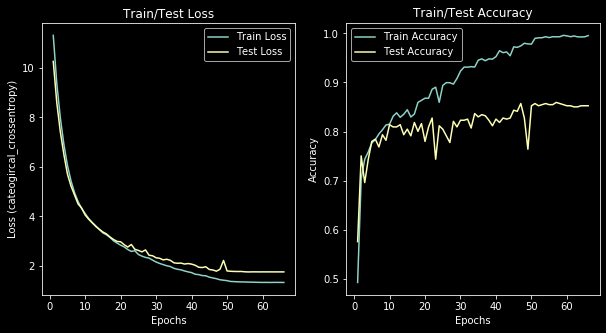

In [18]:
Viz.plot_loss_accuracy(normal_history, 'dark_background', path = 'figures/V1LossAcc_NoEdge_NoAugmentation.png')  

F1 Scores Test
~~~~~~~~~~~~~~~~~~~~~~
No Weapon: 0.9704918032786886
HandGun: 0.8026315789473685
Rifle: 0.783882783882784


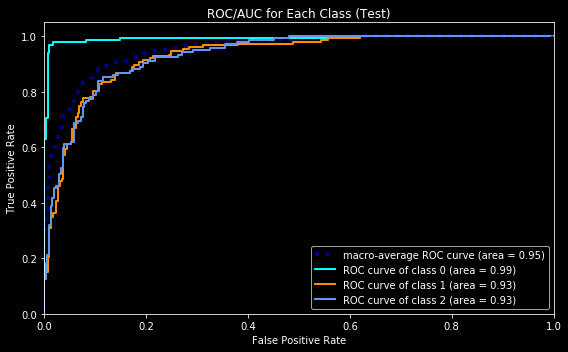

In [19]:
normal_model = get_conv_model(dim)
normal_model.load_weights('ModelWeights/V1_NoEdge_NoAugmentation.h5') #load the best weights before overfitting

Viz.plot_roc_auc(normal_model, x_test, y_test, 'dark_background', 'figures/V1ROC_NoEdge_NoAugmentation.png')

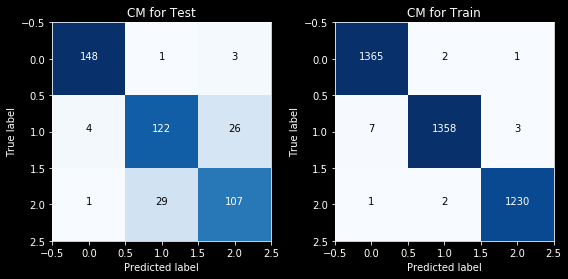

In [20]:
normal_model = get_conv_model(dim)
normal_model.load_weights('ModelWeights/V1_NoEdge_NoAugmentation.h5') #load the best weights before overfitting

y_test_prob = [np.argmax(i) for i in normal_model.predict(x_test)]
y_test_labels = [np.argmax(
    i) for i in y_test]
test_cnf = confusion_matrix(y_test_labels, y_test_prob)

y_train_prob = [np.argmax(i) for i in normal_model.predict(x_train)]
y_train_labels = [np.argmax(i) for i in y_train]
train_cnf = confusion_matrix(y_train_labels, y_train_prob)

Viz.plot_model_cm(test_cnf, train_cnf, classes = ['No Weapon', 'Handgun', 'Rifle'], theme = 'dark_background', 
                  path = 'figures/V1CM_NoEdge_NoAugmentation.png')


# Version 2
- In this version, we will compare augmentation and edge detection within the version 1 dataset, which contains the following: 
    - 0 = No weapon (From negative ROI) 
    - 1 = Pistol (From positive ROI) 
    - 2 = From (From positive ROI) 

### V2: Edge and Augmentation

In [21]:
x_train, x_test, y_train, y_test = func.get_tts('normal', version = 2, edge = True, balance = True)

#test if it worked
cv2.imshow('test', x_train[25])
cv2.waitKey(0)
cv2.destroyAllWindows()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 441/441 [00:01<00:00, 307.67it/s]


Train Value Counts
1    1368
0    1368
2    1233
dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Test Value Counts
1    152
0    152
2    137
dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
X Train Shape
(3969, 150, 150, 1)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
X Test Shape
(441, 150, 150, 1)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [43]:
#prevents overfitting and saves models every time the validation loss improves
early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience=10, min_delta = .00075)
model_checkpoint = ModelCheckpoint('ModelWeights/V2_Edge_Augmentation.h5', verbose = 1, save_best_only=True,
                                  monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')

epochs = 1000
batch_size = 32

dim = (var.norm_dimension[0], var.norm_dimension[1], 1) #edge is 1 dimensional
model = get_conv_model(dim)
augmentation =ImageDataGenerator(rotation_range = 20, width_shift_range = .2, height_shift_range = .2, 
                                                       horizontal_flip = True, shear_range = .15, 
                                 fill_mode = 'nearest', zoom_range = .15)
augmentation.fit(x_train)
normal_history = model.fit_generator(augmentation.flow(x_train, y_train, batch_size = batch_size),
            epochs = epochs, 
     callbacks = [early_stopping, model_checkpoint, lr_plat], validation_data = (x_test, y_test), verbose= 1)

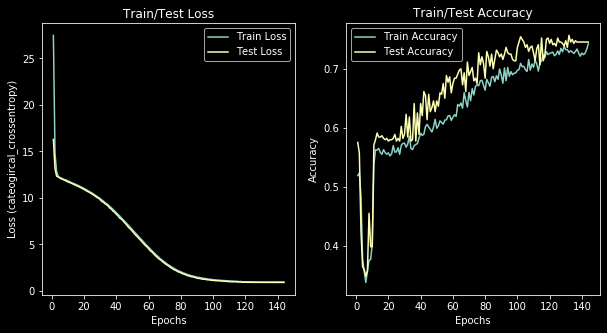

In [23]:
Viz.plot_loss_accuracy(normal_history, 'dark_background', path = 'figures/V2LossAcc_Edge_Augmentation.png')  

F1 Scores Test
~~~~~~~~~~~~~~~~~~~~~~
No Weapon: 0.8819444444444445
HandGun: 0.6987951807228916
Rifle: 0.6717557251908398


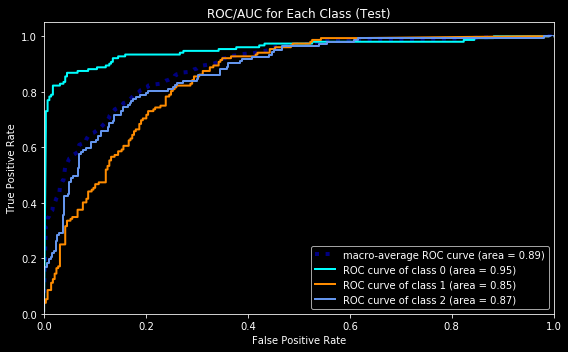

In [24]:
normal_model = get_conv_model(dim)
normal_model.load_weights('ModelWeights/V2_Edge_Augmentation.h5') #load the best weights before overfitting

Viz.plot_roc_auc(normal_model, x_test, y_test, 'dark_background', 'figures/V2ROC_Edge_Augmentation.png')

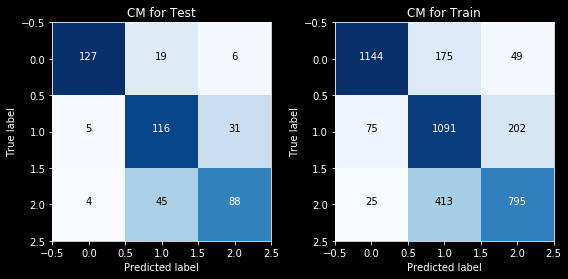

In [25]:
normal_model = get_conv_model(dim)
normal_model.load_weights('ModelWeights/V2_Edge_Augmentation.h5') #load the best weights before overfitting

y_test_prob = [np.argmax(i) for i in normal_model.predict(x_test)]
y_test_labels = [np.argmax(
    i) for i in y_test]
test_cnf = confusion_matrix(y_test_labels, y_test_prob)

y_train_prob = [np.argmax(i) for i in normal_model.predict(x_train)]
y_train_labels = [np.argmax(i) for i in y_train]
train_cnf = confusion_matrix(y_train_labels, y_train_prob)

Viz.plot_model_cm(test_cnf, train_cnf, classes = ['No Weapon', 'Handgun', 'Rifle'], theme = 'dark_background', 
                  path = 'figures/V2CM_Edge_Augmentation.png')


### V2: Edge and No Augmentation

In [44]:
early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience=10, min_delta = .00075)
model_checkpoint = ModelCheckpoint('ModelWeights/V2_Edge_NoAugmentation.h5', verbose = 1, save_best_only=True,
                                  monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')
epochs = 1000
batch_size = 32

dim = (var.norm_dimension[0], var.norm_dimension[1], 1) ##edge is 1 dimensional
    
model = get_conv_model(dim =dim)


normal_history = model.fit(x_train, y_train, batch_size = batch_size,
            epochs = epochs, 
     callbacks = [early_stopping, model_checkpoint, lr_plat], validation_data = (x_test, y_test), verbose= 1)


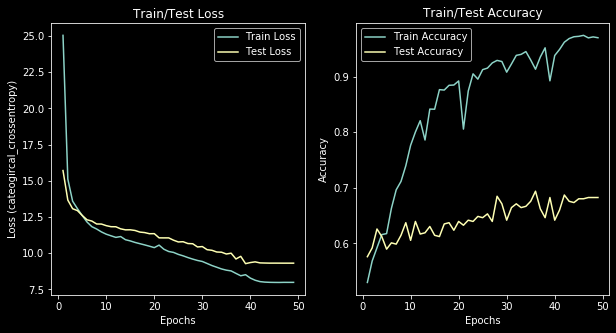

In [27]:
Viz.plot_loss_accuracy(normal_history, 'dark_background', path = 'figures/V2LossAcc_Edge_NoAugmentation.png')  

F1 Scores Test
~~~~~~~~~~~~~~~~~~~~~~
No Weapon: 0.8438538205980066
HandGun: 0.6006600660066007
Rifle: 0.5971223021582734


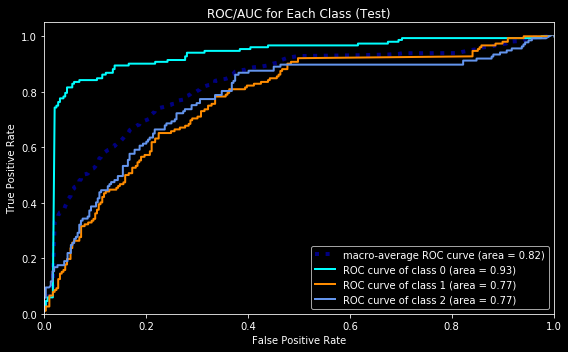

In [28]:
normal_model = get_conv_model(dim)
normal_model.load_weights('ModelWeights/V2_Edge_NoAugmentation.h5') #load the best weights before overfitting

Viz.plot_roc_auc(normal_model, x_test, y_test, 'dark_background', 'figures/V2ROC_Edge_NoAugmentation.png')

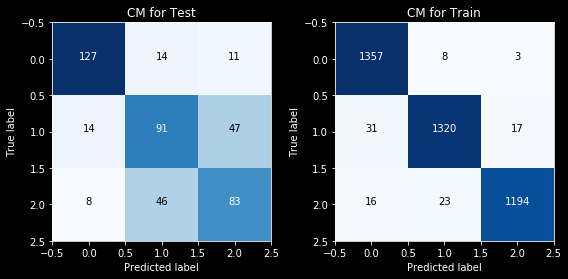

In [29]:
normal_model = get_conv_model(dim)
normal_model.load_weights('ModelWeights/V2_Edge_NoAugmentation.h5') #load the best weights before overfitting

y_test_prob = [np.argmax(i) for i in normal_model.predict(x_test)]
y_test_labels = [np.argmax(
    i) for i in y_test]
test_cnf = confusion_matrix(y_test_labels, y_test_prob)

y_train_prob = [np.argmax(i) for i in normal_model.predict(x_train)]
y_train_labels = [np.argmax(i) for i in y_train]
train_cnf = confusion_matrix(y_train_labels, y_train_prob)

Viz.plot_model_cm(test_cnf, train_cnf, classes = ['No Weapon', 'Handgun', 'Rifle'], theme = 'dark_background', 
                  path = 'figures/V2CM_Edge_NoAugmentation.png')


### V2: No Edge and Augmentation

In [30]:
x_train, x_test, y_train, y_test = func.get_tts('normal', version = 2, edge = False, balance = True)

#test if it worked
cv2.imshow('test', x_train[25])
cv2.waitKey(0)
cv2.destroyAllWindows()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 441/441 [00:01<00:00, 388.01it/s]


Train Value Counts
1    1368
0    1368
2    1233
dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Test Value Counts
1    152
0    152
2    137
dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
X Train Shape
(3969, 150, 150, 3)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
X Test Shape
(441, 150, 150, 3)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [45]:
#prevents overfitting and saves models every time the validation loss improves
early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience=10, min_delta = .00075)
model_checkpoint = ModelCheckpoint('ModelWeights/V2_NoEdge_Augmentation.h5', verbose = 1, save_best_only=True,
                                  monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')

epochs = 1000
batch_size = 32

dim = (var.norm_dimension[0], var.norm_dimension[1], 3) #edge is 1 dimensional
model = get_conv_model(dim)
augmentation =ImageDataGenerator(rotation_range = 20, width_shift_range = .2, height_shift_range = .2, 
                                                       horizontal_flip = True, shear_range = .15, 
                                 fill_mode = 'nearest', zoom_range = .15)
augmentation.fit(x_train)
normal_history = model.fit_generator(augmentation.flow(x_train, y_train, batch_size = batch_size),
            epochs = epochs, 
     callbacks = [early_stopping, model_checkpoint, lr_plat], validation_data = (x_test, y_test), verbose= 1)

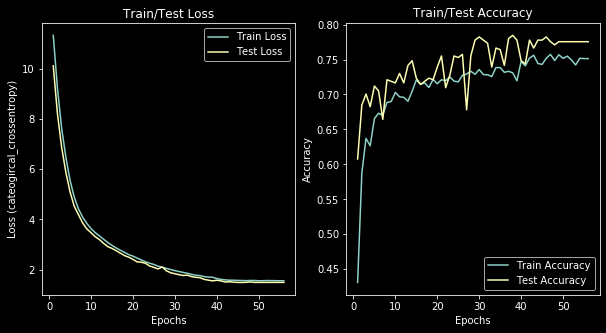

In [32]:
Viz.plot_loss_accuracy(normal_history, 'dark_background', path = 'figures/V2LossAcc_NoEdge_Augmentation.png')  

F1 Scores Test
~~~~~~~~~~~~~~~~~~~~~~
No Weapon: 0.9423728813559322
HandGun: 0.6824324324324325
Rifle: 0.7216494845360824


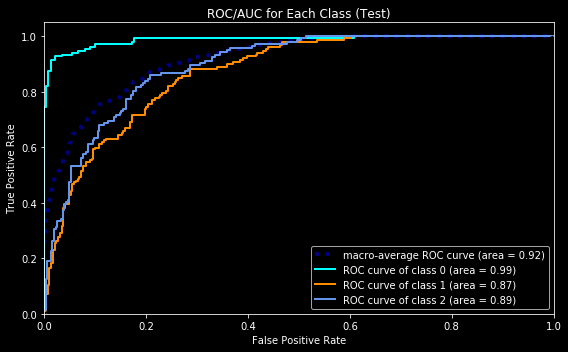

In [33]:
normal_model = get_conv_model(dim)
normal_model.load_weights('ModelWeights/V2_NoEdge_Augmentation.h5') #load the best weights before overfitting

Viz.plot_roc_auc(normal_model, x_test, y_test, 'dark_background', 'figures/V2ROC_NoEdge_Augmentation.png')

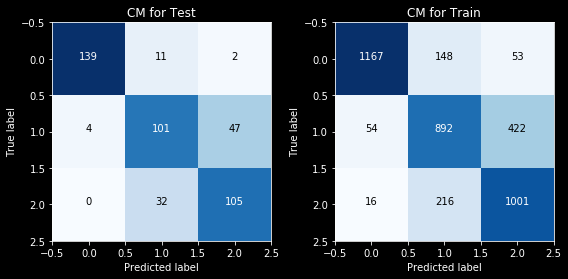

In [34]:
normal_model = get_conv_model(dim)
normal_model.load_weights('ModelWeights/V2_NoEdge_Augmentation.h5') #load the best weights before overfitting

y_test_prob = [np.argmax(i) for i in normal_model.predict(x_test)]
y_test_labels = [np.argmax(
    i) for i in y_test]
test_cnf = confusion_matrix(y_test_labels, y_test_prob)

y_train_prob = [np.argmax(i) for i in normal_model.predict(x_train)]
y_train_labels = [np.argmax(i) for i in y_train]
train_cnf = confusion_matrix(y_train_labels, y_train_prob)

Viz.plot_model_cm(test_cnf, train_cnf, classes = ['No Weapon', 'Handgun', 'Rifle'], theme = 'dark_background', 
                  path = 'figures/V2CM_NoEdge_Augmentation.png')


### V2: No Edge and No Augmentation

In [46]:
early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience=10, min_delta = .00075)
model_checkpoint = ModelCheckpoint('ModelWeights/V2_NoEdge_NoAugmentation.h5', verbose = 1, save_best_only=True,
                                  monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')
epochs = 1000
batch_size = 32

dim = (var.norm_dimension[0], var.norm_dimension[1], 3) 
    
model = get_conv_model(dim =dim)


normal_history = model.fit(x_train, y_train, batch_size = batch_size,
            epochs = epochs, 
     callbacks = [early_stopping, model_checkpoint, lr_plat], validation_data = (x_test, y_test), verbose= 1)


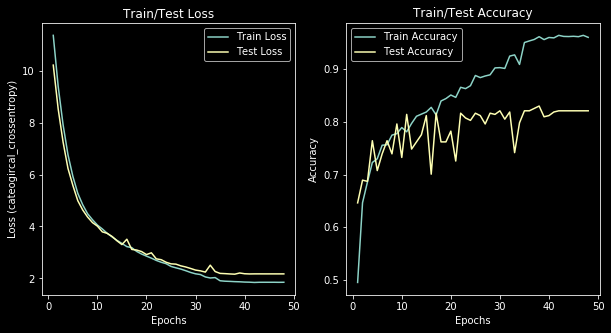

In [36]:
Viz.plot_loss_accuracy(normal_history, 'dark_background', path = 'figures/V2LossAcc_NoEdge_NoAugmentation.png')  

F1 Scores Test
~~~~~~~~~~~~~~~~~~~~~~
No Weapon: 0.9368770764119602
HandGun: 0.7722772277227723
Rifle: 0.776978417266187


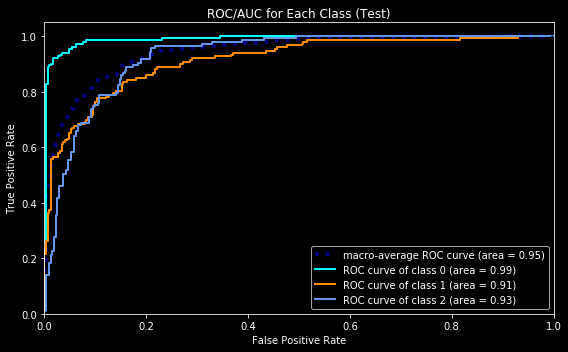

In [37]:
normal_model = get_conv_model(dim)
normal_model.load_weights('ModelWeights/V2_NoEdge_NoAugmentation.h5') #load the best weights before overfitting

Viz.plot_roc_auc(normal_model, x_test, y_test, 'dark_background', 'figures/V2ROC_NoEdge_NoAugmentation.png')

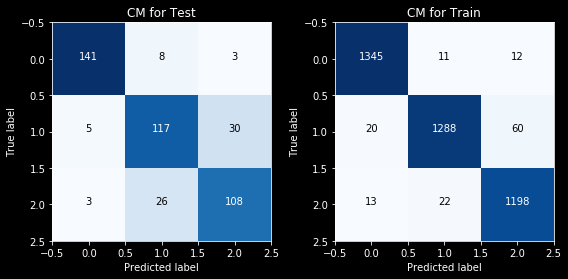

In [38]:
normal_model = get_conv_model(dim)
normal_model.load_weights('ModelWeights/V2_NoEdge_NoAugmentation.h5') #load the best weights before overfitting

y_test_prob = [np.argmax(i) for i in normal_model.predict(x_test)]
y_test_labels = [np.argmax(
    i) for i in y_test]
test_cnf = confusion_matrix(y_test_labels, y_test_prob)

y_train_prob = [np.argmax(i) for i in normal_model.predict(x_train)]
y_train_labels = [np.argmax(i) for i in y_train]
train_cnf = confusion_matrix(y_train_labels, y_train_prob)

Viz.plot_model_cm(test_cnf, train_cnf, classes = ['No Weapon', 'Handgun', 'Rifle'], theme = 'dark_background', 
                  path = 'figures/V2CM_NoEdge_NoAugmentation.png')


## Conclusion: Final Model



### Version 1 (F1 Scores- Test)
- **Edge & Augmentation**
    - No Weapon: 1.0
    - HandGun: 0.6466165413533834
    - Rifle: 0.6987179487179487
- **Edge & No Augmentation**
    - No Weapon: 0.9934640522875817
    - HandGun: 0.49814126394052044
    - Rifle: 0.5667752442996742
- **No edge & Augmentation** 
    - No Weapon: 0.8875739644970414
    - HandGun: 0.6844106463878326
    - Rifle: 0.6619217081850534
- **No Edge & No Augmentation** (BEST)
    - No Weapon: 0.9704918032786886
    - HandGun: 0.8026315789473685
    - Rifle: 0.783882783882784
            
### Version 2 (F1 Scores - Test)
- **Edge & Augmentation**
    - No Weapon: 0.8819444444444445
    - HandGun: 0.6987951807228916
    - Rifle: 0.6717557251908398
- **Edge & No Augmentation**
    - No Weapon: 0.8438538205980066
    - HandGun: 0.6006600660066007
    - Rifle: 0.5971223021582734
- **No edge & Augmentation** 
    - No Weapon: 0.9423728813559322
    - HandGun: 0.6824324324324325
    - Rifle: 0.7216494845360824
- **No Edge & No Augmentation** (BEST)
    - No Weapon: 0.9368770764119602
    - HandGun: 0.7722772277227723
    - Rifle: 0.776978417266187



### Version 1 (ROC Scores- Test)
- **Edge & Augmentation**
    - No Weapon: 1.0
    - HandGun: 0.87
    - Rifle: 0.86
    - Averaged: .91
- **Edge & No Augmentation**
    - No Weapon: 1.0
    - HandGun: 0.78
    - Rifle: 0.79
    - Averaged: .86
- **No edge & Augmentation** 
    - No Weapon: 0.99
    - HandGun: 0.87
    - Rifle: 0.85
    - Averaged: .91
- **No Edge & No Augmentation** (BEST)
    - No Weapon: 0.99
    - HandGun: 0.93
    - Rifle: 0.93
    - Averaged: .95
            
### Version 2 (ROC Scores - Test)
- **Edge & Augmentation**
    - No Weapon: 0.95
    - HandGun: 0.85
    - Rifle: 0.87
    - Averaged: .89
- **Edge & No Augmentation**
    - No Weapon: 0.93
    - HandGun: 0.77
    - Rifle: 0.77
    - Averaged: .82
- **No edge & Augmentation** 
    - No Weapon: 0.99
    - HandGun: 0.87
    - Rifle: 0.89
    - Averaged: .92
- **No Edge & No Augmentation** (BEST)
    - No Weapon: 0.99
    - HandGun: 0.91
    - Rifle: 0.93
    - Averaged: .95


## F1 Scores
- Because the problem is meant to solve weapon detection, I first looked at the best models that showed the highest F1 score for detecting pistols and rifles.  
    - **Version 1 --> No Edge and No Augmentation**
        - No Weapon: 0.9704918032786886
        - HandGun: 0.8026315789473685
        - Rifle: 0.783882783882784
    - **Version 2 --> No Edge and No Augmentation**
        - No Weapon: 0.9368770764119602
        - HandGun: 0.7722772277227723
        - Rifle: 0.776978417266187

## ROC Scores 
- To get a better understanding of how the model performs for each class, I then compared the ROC scores between each model. 
    - **Version 1 --> No Edge and No Augmentation**
        - No Weapon: 0.99
        - HandGun: 0.93
        - Rifle: 0.93
        - Averaged: .95
    - **Version 2 --> No Edge and No Augmentation**
        - No Weapon: 0.99
        - HandGun: 0.91
        - Rifle: 0.93
        - Averaged: .95
    
## Accuracy 

- As a final comparison, I looked at the differences in overall accuracy and loss between the two No Edge and No Augmentation models.  
- Because Version 2 had a higher accuracy and a lower loss than compared with version 1, I chose to use Version 2 as the final model.  

- The final architecture of the model is Version 2, No edge and No Augmentation.  



# LIME - Feature Extraction

- In this section of the notebook, I use [LIME](https://github.com/marcotcr/lime)- a python package that can be used for feature extraction of black box models 
- Below, the areas that are green are those that the algorithm deems "important" for making a prediction 
- This technique is useful because it allowed me to understand what the neural network is basing its predictions off of

In [1]:
import cv2 
import os
from PyFunctions import var 
from PyFunctions import Functions as func
from PyFunctions import ModelFunc as mf
import numpy as np
import matplotlib.pyplot as plt

Using plaidml.keras.backend backend.


Creating Lime Image for AR.jpg



Creating Lime Image for AR2.jpg



Creating Lime Image for NoWeap.jpg



Creating Lime Image for Pistol.jpg



Creating Lime Image for Pistol2.jpg



Creating Lime Image for Pistol3.jpg


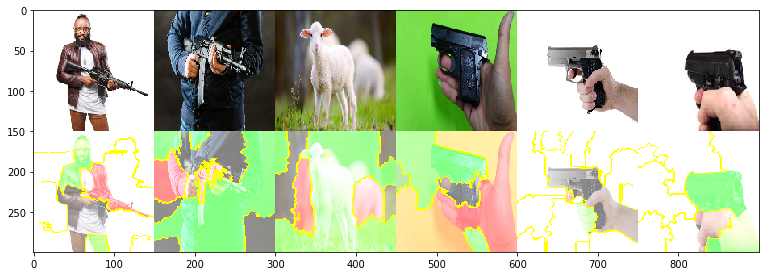

In [3]:
model_dim = var.norm_dimension
dim = (model_dim[0], model_dim[1], 3)

model = mf.get_conv_model(dim)

model.load_weights('ModelWeights/Normal/V2_NoEdge_NoAugmentation.h5')
func.get_lime_predictions('Tests/Photos', model, dim, save_name = 'Figures/NormalLime.png')